In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch

In [11]:
data = pd.read_csv("data.csv")

In [12]:
data_2 = data.drop(['X00'], axis=1)
X = data_2.drop(['y'],axis =1 )
Y = data_2['y']

Y_2 = Y.to_numpy()

Y_2[Y_2!=1]=0

In [13]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y_2, test_size=0.3)

In [14]:
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
X_new = np.expand_dims(X_train, 1) # necesario para que las dimensiones sean [batch, channel, width]
feature_maps = torch.autograd.Variable(torch.Tensor(X_new).float())
print(feature_maps.size())

n = torch.nn.Conv1d(1,2, 8, stride=1) # in-channels = 1, out-channels = 10, kernel=8
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.MaxPool1d(kernel_size=8)
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.Conv1d(2, 1, 8, stride=1)
feature_maps = n(feature_maps)
print(feature_maps.size())

torch.Size([8050, 1, 178])
torch.Size([8050, 2, 171])
torch.Size([8050, 2, 21])
torch.Size([8050, 1, 14])


# Lr = 0.1 - Kernel = 8 - output channels = 2

In [20]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 2, kernel_size=8, stride=1),
    torch.nn.MaxPool1d(kernel_size=8),
    torch.nn.Conv1d(2, 1, kernel_size=8, stride=1),
    torch.nn.Linear(14, 2)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #lr: learning rate
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)


for epoch in range(epochs):
    X_new = np.expand_dims(X_train, 1) 
    inputs = torch.autograd.Variable(torch.Tensor(X_new).float())
    targets = torch.autograd.Variable(torch.Tensor(Y_train).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out = out.squeeze(dim=1) # necesario para quitar la dimension intermedia de channel
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(Y_train, Y_predicted, average='macro')
    
    X_new = np.expand_dims(X_test, 1)
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(Y_test, Y_predicted_test, average='macro')

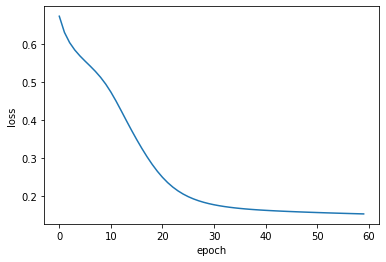

In [21]:
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

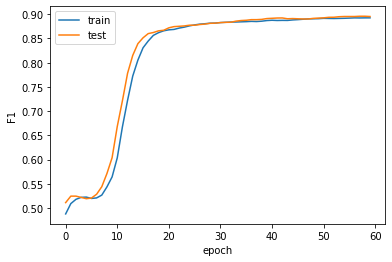

In [22]:
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()
plt.show()